<h2>Capsule Nets over MNIST... </h2>
<h4> This is a tensorflow implementation of the paper "Dynamic routing between capsules" by Sara Sabour, Nicholas Frosst, and Geoffrey Hinton </h4>

In [40]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt


In [33]:
tf.reset_default_graph()

In [28]:
np.random.seed(42)
tf.set_random_seed(42)

In [29]:
from tensorflow.examples.tutorials.mnist  import input_data
mnist = input_data.read_data_sets("../datasets_lib/mnist/")

Extracting ../datasets_lib/mnist/train-images-idx3-ubyte.gz
Extracting ../datasets_lib/mnist/train-labels-idx1-ubyte.gz
Extracting ../datasets_lib/mnist/t10k-images-idx3-ubyte.gz
Extracting ../datasets_lib/mnist/t10k-labels-idx1-ubyte.gz


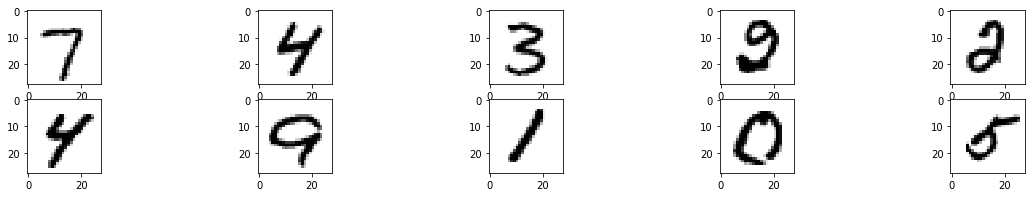

Nd here goes the labels...
[7 4 3 2 2 4 9 1 0 5]


In [30]:
n_samples = 10
start_idx = 100
plt.figure(figsize=(n_samples* 2,3))
for index_i in range(n_samples):
    plt.subplot(2,n_samples/2,index_i+1)
    sample_img = mnist.train.images[start_idx+index_i].reshape(28,28)
    plt.imshow(sample_img,cmap='binary')
    #plt.axis("off")
plt.show()
print( "Nd here goes the labels...")
print (mnist.train.labels[start_idx:start_idx+n_samples])

In [37]:
tf.reset_default_graph()

<h3> <bold> <u>Capsnet flow from input to Loss (Diagram) </bold></h3></u><br>

```
                            Loss
                              ↑
                    ┌─────────┴─────────┐
      Labels → Margin Loss      Reconstruction Loss
                    ↑                   ↑
                  Length             Decoder
                    ↑                   ↑ 
             Digit Capsules ────Mask────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Primary Capsules
                    ↑      
               Input Images
```

<h2> Let's now build from bottom up ..one by one </h2>
<h3> 1. Input Images: </h3>

In [38]:
X = tf.placeholder(shape=[None,28,28,1],dtype=tf.float32,name="X")

<h3>2. Primary Capsule </h3>
<p> <b> &nbsp; 2.1</b> : The first layer is composed of 32 maps of 6 x 6 capsules each. Each capsule will output an 8D vector.</p>

In [41]:
# Let's set the primary capsule hyper params

prim_caps1_num_maps = 32
prim_caps_inp_dim = 6
prim_caps1_num_caps = prim_caps1_num_maps * prim_caps_inp_dim * prim_caps_inp_dim # 32 x 6 x 6 = 1152 primary capsules total
prim_caps_out_dim = 8

# Apply first 2 normal conv layers

conv1_params = {
    "filters":256,
    "kernel_size": 9,
    "strides": 1,
    "padding":"valid", # no padding
    "activation" : tf.nn.relu,
}

conv2_params = {
    "filters": prim_caps1_num_maps * prim_caps_out_dim, # 32 x 8 = 256 
    "kernel_size": 9,
    "strides": 2,
    "padding":"valid", #no paddding
    "activation":tf.nn.relu
}


conv1 = tf.layers.conv2d(X,name='conv1',**conv1_params)
conv2 = tf.layers.conv2d(conv1,name='conv2',**conv2_params)

"""
===============================================================
A short note on how we are reaching final feature map of 6x6:
===============================================================
1. We use a kernel of size 9  with no padding. 
    * So after conv1, the image size reduced by 9-1=8 pixels [top,bottom,left,right]
        ie. 28 x 28 ==> 20 x 20
2. Now goes conv2, 
    * The output size again reduced by 9-1=8 pixels. On the top of that, given stride '2' , the image again 
      gets divided by half
        ie. 20 x 20 ==> 12 x 12  ==> 6 x 6
    
"""



#  So at this point , we are clear about how to generate 32 maps of 6 x 6 features,
# Now we have to map it to a bunch of 8D output vectors, which represents the outputs of primary capsules.

"""
=================================================
Explanation on primary capsule output dimension:
=================================================

1. The output of conv2 is an array containing 256 ( <== 32 x 8 )  feature maps for each instance. The dimension of 
    each feature map is 6 x 6. ie , the output is [batch_size,6,6,256] 

2.  Now we have to map this to 32 vectors of 8-D . 
    ie. reshape [batch_size,6,6,256] => [batch_size,6,6,32,8]

3. But the first capsule layer is fully connected layer, we can flatten the 6 x 6 grid
    ie. reshape to [batch_size,6x6x32, 8]


"""


caps1_raw = tf.reshape(conv2,[-1,prim_caps1_num_caps,prim_caps_out_dim],name='caps1_row')


"""
================
Squash function:
================
                ||s||^2             s
squash(s)  = ---------------  * ----------
                1+ ||s||^2        ||s||
                

1. This function is used to scale the output values between 0 and 1
2. We don't use tf.norm() because of divide by zero problem, ending in NaN a lot.
3. The squash() function will squash all vectors in the given array, along the given axis (by default, the last axis).

"""
def squash(s,axis=-1,epsilon=1e-7,name=None):
    with tf.name_scope(name, default_name='squash'):
        squared_norm = tf.reduce_sum(tf.square(s),axis=axis,keep_dims=True)
        safe_norm = tf.sqrt(squared_norm+epsilon)
        squash_factor = squared_norm/(1.0 + squared_norm)
        unit_vec = s / safe_norm
        return squash_factor * unit_vec
    

        

#Now apply squash on the capsules output calculated
caps1_output = squash(caps1_raw,name="caps1_output")

print ("Primary Capsule Part Done..")

Primary Capsule Part Done..
